# EECS 531 - A1
### Tristan Maidment (tdm47)
### Assignment 1

#### Exercise 3

As with the previous two assignments, this one uses the same imports.

In [1]:
%matplotlib inline
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np

At this point, I define the `correlation` function.  This function is the similar to the `convolution` function, with the absense of the initial rotation.  

Some changes include:

1. I define the padded image with a white background in order to match the text background.

2. Instead of element-wise matrix multiplication, then summation, I do element-wise matrix subtraction, square each element, then sum.

In [2]:
def correlation(img, kernel):
    #kernel = np.flip(np.flip(kernel, 1), 0) #flip the kernel on both axis
    
    width, height, channels = img.shape 
    k_width, k_height = kernel.shape
    
    k_half_width = math.floor(k_width/2)
    k_half_width_2 = math.ceil(k_width/2)
    k_half_height = math.floor(k_height/2)
    k_half_height_2 = math.ceil(k_height/2)
        
    ret = np.zeros(img.shape) 
    
    img_pad = np.ones((width + k_width + 1 , height + k_width + 1, channels))
    img_pad[k_half_width : -k_half_width_2 - 1,
            k_half_height : -k_half_height_2 - 1] = img 
    
    for x in range(width):
        for y in range(height):
            for c in range(channels):
                ret[x, y, c] = np.power(np.subtract(img_pad[x: x + k_width, 
                                                            y  : y + k_height,
                                                            c], kernel), 2).sum()
    return ret/ret.max()

I now import the image containg the text that I will be attempting to match the letter `h` to.  In addition, I normalize the image to range `0. - 1.`.

In [3]:
img = cv2.imread('./characters.png', 1) #load all three channels, due to rendering problems
if img is not None:
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
img = img/img.max()

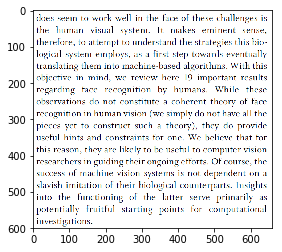

In [4]:
plt.imshow(img)
plt.show()

I define a function that will create a square kernel using a given template image.  To make a template, I used a screenshot I took of the letter `h`.

This template was made with a screenshot of the text.

In [5]:
def create_kernel(img):
    patch = cv2.imread(img, 0)
    patch = patch/patch.max()
    width, height = patch.shape
    k_size = np.amax(patch.shape)
    ret = np.ones((k_size, k_size))
    x_diff = math.floor((k_size - width)/2)
    y_diff = math.floor((k_size - height)/2)
    ret[x_diff:k_size-x_diff,y_diff:k_size-y_diff] = patch
    return ret

Here is how the matching template looks.

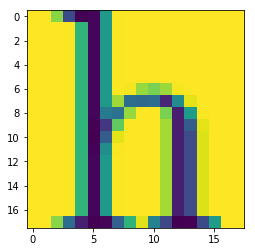

In [6]:
kernel = create_kernel('./h.png')
plt.imshow(kernel)
plt.show()

To determine where the h is located, we run the correlation function on the image.  As we discussed in class, a lower correlation (not really intuitive based on how I named it) value implies that the template/kernel is more similar to the current pixel location.  With this knowledge, we can determine the probability of each part of the image containing the kernel.

In [7]:
probability = correlation(img, kernel)

To see a "heat map" of the likelhood of at `h` at each point, I have displayed the correlation below.  It appears to look like a blurred image, but that's due to each letter be somewhat likely of being an h.  The most likely spots have the darkest pixels.

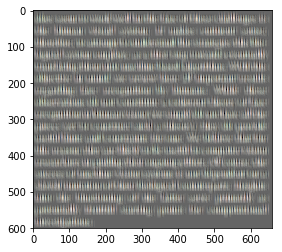

In [8]:
plt.imshow(probability)
plt.show()

To filter the probability map, I set a limit on what classifies as an `h`.  The purpose of this function is to select pixels used for the center of the bounding boxes.

In [9]:
def threshold(supp, t2):
    ret = np.zeros_like(supp)
    
    width, height, channels = supp.shape
    k_width, k_height = kernel.shape
    k_half_width = math.ceil(k_width/2)
    k_half_height = math.ceil(k_height/2)
    
    for x in range(k_half_width,width-k_half_width):
        for y in range(k_half_height,height-k_half_height):
                theta = np.sum(supp[x, y, :])
                if theta < t2:
                    ret[x, y, :] = 1.
                else:
                    ret[x, y, :] = 0.
    return ret

I then output a matrix of pixels that pass the threshold and are classified as the letter `h`.  The white dot indicates that the template matching found a high enough correlation at that location.

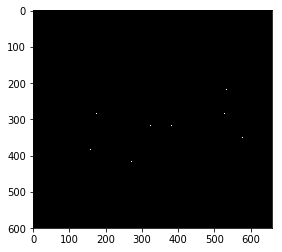

In [10]:
heatmap = threshold(probability, 0.075 * 3)
plt.imshow(heatmap, cmap = "BuPu")
plt.show()

Here, I define a simple function that iterates through the pixels and applys a template sized bounding box at the various locations selected by the previous methods.

In [11]:
# draw rectangles
def plot_squares(img, heatmap):
    p_width, p_height, channels = heatmap.shape
    x_offset = math.floor(kernel.shape[0]/2)
    y_offset = math.floor(kernel.shape[1]/2)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for x in range(p_width):
        for y in range(p_height):
            if heatmap[x, y, 0] == 1.:
                rect = patches.Rectangle((y - y_offset,x - x_offset),kernel.shape[0],kernel.shape[1],linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
    plt.show()
    fig.savefig("./output.png", dpi=240)  # save the image to the working directory - for Exercise 4

Here is the output of the matching process, with the selected spots highlighted by red bounding boxes. With a threshold value of 0.08, every `h` is correctly classified.  I will explore this relationship in Exercise 4.

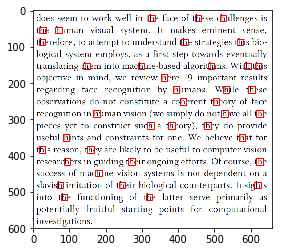

Number of detections: 38.0


In [12]:
plot_squares(img, heatmap)
print("Number of detections:",heatmap.sum() / 3) # due to 3 RGB channels